In [1]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import analysis_utils as au
import CMR_IA as cmr
sns.set_context('paper')
pd.set_option('display.max_columns', None)

In [2]:
with open("../Data/simu1_design.pkl", 'rb') as inp:
    df = pickle.load(inp)
df

,subject_ID,position,item,itemno,category_label,lag,old,session
0,58,0,UNDERWEAR,282,Clothing,0,False,0
1,58,1,JEANS,139,Clothing,0,False,0
2,58,2,JACKET,138,Clothing,0,False,0
3,58,3,TABLET,263,Electronics,0,False,0
4,58,4,COMPUTER,62,Electronics,0,False,0
...,...,...,...,...,...,...,...,...
579995,337,575,LAKE,148,Landscapes,0,False,999
579996,337,576,PIE,201,Desserts,78,True,999
579997,337,577,LOBSTER,160,OceanAnimals,90,True,999
579998,337,578,MAPLE,161,Trees,118,True,999


### Run CMR-IA

In [3]:
s_mat = np.load('../Data/wordpools/simu1_300_smat.npy')

In [4]:
params = cmr.make_default_params()
params.update(
    beta_enc = 0.635,
    beta_rec = 0.5,
    beta_rec_post = 0.888,
    gamma_fc = 0.972,
    s_fc = 0.823,
    c_thresh = 0.377,
    a = 2800,
    b = 2.14
)
params

{'beta_enc': 0.635,
 'beta_rec': 0.5,
 'beta_rec_post': 0.888,
 'beta_distract': None,
 'phi_s': 2,
 'phi_d': 0.5,
 's_cf': 0,
 's_fc': 0.823,
 'kappa': 0.5,
 'eta': 0.5,
 'omega': 8,
 'alpha': 4,
 'c_thresh': 0.377,
 'lamb': 0.5,
 'rec_time_limit': 60000.0,
 'dt': 10,
 'nitems_in_accumulator': 50,
 'max_recalls': 50,
 'learn_while_retrieving': False,
 'a': 2800,
 'b': 2.14,
 'm': 0,
 'n': 0,
 'gamma_fc': 0.972,
 'gamma_cf': 0.5}

In [5]:
df_simu = cmr.run_conti_recog_multi_sess(params,df,s_mat)
df_simu

CMR Time: 463.8379256725311


,session,position,itemno,s_resp,s_rt,csim
0,0,0,282,0.0,1249.619873,0.000000
1,0,1,139,0.0,2295.811523,0.284228
2,0,2,138,0.0,2704.962891,0.360864
3,0,3,263,0.0,2720.604248,0.363558
4,0,4,62,1.0,2788.553223,0.378914
...,...,...,...,...,...,...
579995,999,575,148,0.0,2795.205322,0.376199
579996,999,576,201,0.0,2767.722900,0.371582
579997,999,577,160,1.0,2750.840820,0.385277
579998,999,578,161,0.0,2645.470215,0.350472


In [6]:
df_simu = df_simu.merge(df,on=['session','position','itemno'])
df_simu

,session,position,itemno,s_resp,s_rt,csim,subject_ID,item,category_label,lag,old
0,0,0,282,0.0,1249.619873,0.000000,58,UNDERWEAR,Clothing,0,False
1,0,1,139,0.0,2295.811523,0.284228,58,JEANS,Clothing,0,False
2,0,2,138,0.0,2704.962891,0.360864,58,JACKET,Clothing,0,False
3,0,3,263,0.0,2720.604248,0.363558,58,TABLET,Electronics,0,False
4,0,4,62,1.0,2788.553223,0.378914,58,COMPUTER,Electronics,0,False
...,...,...,...,...,...,...,...,...,...,...,...
579995,999,575,148,0.0,2795.205322,0.376199,337,LAKE,Landscapes,0,False
579996,999,576,201,0.0,2767.722900,0.371582,337,PIE,Desserts,78,True
579997,999,577,160,1.0,2750.840820,0.385277,337,LOBSTER,OceanAnimals,90,True
579998,999,578,161,0.0,2645.470215,0.350472,337,MAPLE,Trees,118,True


### Preprocesssing

In [7]:
# calculate the rolling category length
rolling_window = 9
category_label_dummies = df_simu['category_label'].str.get_dummies()
category_label_dummies.columns = ['cl_' + col for col in category_label_dummies.columns]
category_label_dummies_events = pd.concat([df_simu, category_label_dummies], axis=1)
cl_rolling_sum = category_label_dummies_events.groupby('session').rolling(rolling_window, min_periods=1, on='position')[category_label_dummies.columns].sum().reset_index()
df_rollcat = df_simu.merge(cl_rolling_sum, on=['session', 'position'])
df_simu['roll_cat_label_length'] = df_rollcat.apply(lambda x: x['cl_' + x['category_label']], 1) # how many cat within 10 window
df_simu['roll_cat_label_length'] = df_simu['roll_cat_label_length'] - 1 # how many cat in previous 9 window. not include self

# add rolling category length level
df_simu['roll_cat_len_level']= pd.cut(x=df_simu.roll_cat_label_length, 
                                bins=[0, 1, 2, np.inf], right=False, include_lowest = True,
                                labels=['0', '1', '>=2']).astype('str')

df_simu

,session,position,itemno,s_resp,s_rt,csim,subject_ID,item,category_label,lag,old,roll_cat_label_length,roll_cat_len_level
0,0,0,282,0.0,1249.619873,0.000000,58,UNDERWEAR,Clothing,0,False,0.0,0
1,0,1,139,0.0,2295.811523,0.284228,58,JEANS,Clothing,0,False,1.0,1
2,0,2,138,0.0,2704.962891,0.360864,58,JACKET,Clothing,0,False,2.0,>=2
3,0,3,263,0.0,2720.604248,0.363558,58,TABLET,Electronics,0,False,0.0,0
4,0,4,62,1.0,2788.553223,0.378914,58,COMPUTER,Electronics,0,False,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
579995,999,575,148,0.0,2795.205322,0.376199,337,LAKE,Landscapes,0,False,6.0,>=2
579996,999,576,201,0.0,2767.722900,0.371582,337,PIE,Desserts,78,True,0.0,0
579997,999,577,160,1.0,2750.840820,0.385277,337,LOBSTER,OceanAnimals,90,True,0.0,0
579998,999,578,161,0.0,2645.470215,0.350472,337,MAPLE,Trees,118,True,0.0,0


In [8]:
# focus on old items
df_old = df_simu.loc[df_simu.lag > 0].reset_index(drop=True)

# add log and log lag bin
df_old['log_lag'] = np.log(df_old['lag'])
df_old['log_lag_bin'] = pd.cut(df_old['log_lag'], np.arange(df_old['log_lag'].max()+1), labels=False, right=False)
df_old

,session,position,itemno,s_resp,s_rt,csim,subject_ID,item,category_label,lag,old,roll_cat_label_length,roll_cat_len_level,log_lag,log_lag_bin
0,0,22,138,0.0,2671.772705,0.355095,58,JACKET,Clothing,20,True,0.0,0,2.995732,2
1,0,25,234,0.0,2795.745850,0.376289,58,SHELF,Furniture,13,True,1.0,1,2.564949,2
2,0,26,72,1.0,2786.402344,0.379275,58,CROWBAR,Tools,19,True,0.0,0,2.944439,2
3,0,28,238,0.0,2762.963623,0.370778,58,SHOVEL,Tools,19,True,1.0,1,2.944439,2
4,0,29,263,1.0,2786.103760,0.379325,58,TABLET,Electronics,26,True,0.0,0,3.258097,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279995,999,573,84,1.0,2794.872314,0.377857,337,DOVE,Birds,46,True,1.0,1,3.828641,3
279996,999,576,201,0.0,2767.722900,0.371582,337,PIE,Desserts,78,True,0.0,0,4.356709,4
279997,999,577,160,1.0,2750.840820,0.385277,337,LOBSTER,OceanAnimals,90,True,0.0,0,4.499810,4
279998,999,578,161,0.0,2645.470215,0.350472,337,MAPLE,Trees,118,True,0.0,0,4.770685,4


### Recency

In [9]:
df_lagcnt = df_simu.groupby(['lag']).s_resp.count().to_frame(name='cnt').reset_index()
df_lagcnt = df_lagcnt.loc[(df_lagcnt.lag <= 41) & (df_lagcnt.lag > 0)]
# df_lagcnt

In [10]:
df_laggp = df_simu.groupby(['lag']).s_resp.mean().to_frame(name='hr').reset_index()
df_laggp.lag = df_laggp.lag.astype('int')
df_laggp = df_laggp.loc[(df_laggp.lag <= 41) & (df_laggp.lag > 0)]

selected_lag = np.array([0,1,2,4,6,8,16,24,32,40])
selected_lag_1 = selected_lag + 1
df_laggp = df_laggp.loc[np.isin(df_laggp.lag, selected_lag_1)]
df_laggp

,lag,hr
1,1,0.811816
2,2,0.597746
3,3,0.440989
5,5,0.408123
7,7,0.408879
9,9,0.402649
17,17,0.388425
25,25,0.360386
33,33,0.370062
41,41,0.398128


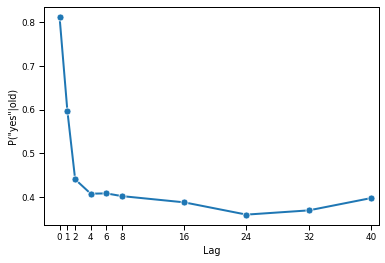

In [11]:
# plt.subplots(figsize=(10,5))
sns.lineplot(data=df_laggp, x='lag', y='hr', linewidth=2, marker='o', markersize = 7)
plt.xlabel('Lag')
plt.ylabel('P("yes"|old)')
plt.xlim([-1,42])
plt.xticks(ticks=selected_lag_1, labels = selected_lag)
plt.savefig('fig/simu1_recency.pdf')
plt.show()

### Recency & Similarity

,lag,roll_cat_len_level,hr
4,1,>=2,0.773742
6,2,>=2,0.560362
8,3,>=2,0.465827
10,4,>=2,0.463271
12,5,>=2,0.387344
...,...,...,...
108,38,>=2,0.569170
109,39,0,0.357283
111,39,>=2,0.492647
112,40,0,0.349164


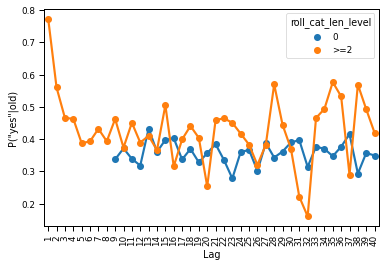

In [12]:
df_laggp = df_simu.groupby(['lag','roll_cat_len_level']).s_resp.mean().to_frame(name='hr').reset_index()
df_laggp.lag = df_laggp.lag.astype('int')
df_laggp = df_laggp.loc[(df_laggp.lag <= 40) & (df_laggp.lag > 0)]
df_laggp = df_laggp.loc[np.isin(df_laggp.roll_cat_len_level, ['0', '>=2'])]
df_laggp.roll_cat_len_level = df_laggp.roll_cat_len_level.astype("category").cat.reorder_categories(['0', '>=2'])
display(df_laggp)

sns.pointplot(data=df_laggp, y='hr', x='lag', hue = 'roll_cat_len_level')
plt.xlabel('Lag')
plt.ylabel('P("yes"|old)')
plt.xticks(rotation=90)
# plt.savefig('result/behav_hit_recency.jpg')
plt.show()

In [13]:
def loglag_rollcat(df, resp_col):

    df_rollcat_laggp = df.groupby(['subject_ID','roll_cat_len_level','log_lag_bin'])[resp_col].mean()
    df_rollcat_laggp = df_rollcat_laggp.to_frame(name='hr').reset_index()
    df_rollcat_laggp = au.loftus_masson(df_rollcat_laggp, 'subject_ID', ['roll_cat_len_level', 'log_lag_bin'], 'hr')
    
    df_rollcat_laggp = df_rollcat_laggp.loc[np.isin(df_rollcat_laggp.roll_cat_len_level,['0','>=2'])]
    df_rollcat_laggp.roll_cat_len_level = df_rollcat_laggp.roll_cat_len_level.astype("category").cat.reorder_categories(['0', '>=2'])
    
    df_rollcat_laggp['log_lag_disp'] = np.e**df_rollcat_laggp.log_lag_bin
    
    display(df_rollcat_laggp)
    
    if resp_col == 's_resp':
        ci = None
        linestyle = '-'
    else:
        ci = 95
        linestyle = '--'

    g=sns.lineplot(data=df_rollcat_laggp, y='adj_hr', x='log_lag_disp', hue = 'roll_cat_len_level', ci=ci, marker = 'o', markersize = 7)
    g.set(ylabel='P("Yes" | Old)', xlabel='Lag')
    
    selected_lag = np.array([1,np.e,np.e**2,np.e**3,np.e**4,np.e**5])
    plt.xticks(ticks=selected_lag, labels = ['1','e','e2','e3','e4','e5'])
    plt.xlim([0,150])
    plt.legend(title = "num of same-cat in prev 8 items")

,subject_ID,roll_cat_len_level,log_lag_bin,hr,M,M_S,adj_hr,log_lag_disp
0,2,0,2,0.523810,0.433661,0.449089,0.508381,7.389056
1,2,0,3,0.409836,0.433661,0.449089,0.394408,20.085537
2,2,0,4,0.263158,0.433661,0.449089,0.247730,54.598150
3,2,0,5,0.333333,0.433661,0.449089,0.317905,148.413159
10,2,>=2,0,0.800000,0.433661,0.449089,0.784572,1.000000
...,...,...,...,...,...,...,...,...
7606,656,>=2,1,0.666667,0.433661,0.409300,0.691027,2.718282
7607,656,>=2,2,0.800000,0.433661,0.409300,0.824361,7.389056
7608,656,>=2,3,0.222222,0.433661,0.409300,0.246583,20.085537
7609,656,>=2,4,0.400000,0.433661,0.409300,0.424361,54.598150


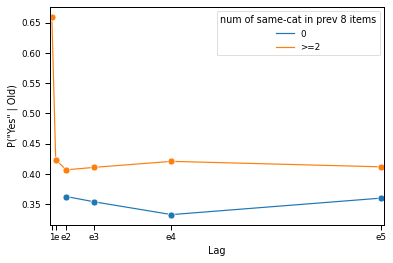

In [14]:
loglag_rollcat(df_old.query('log_lag_bin <= 5'),'s_resp')
plt.savefig('fig/simu1_recsim.pdf')

### RT

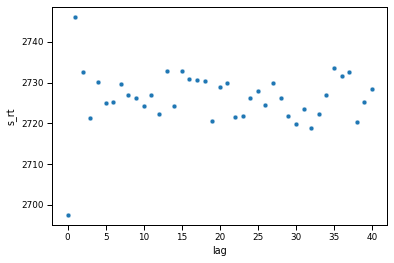

In [15]:
df_laggp = df_simu.groupby('lag').s_rt.mean().to_frame(name='rt_mean').reset_index()
df_laggp.lag = df_laggp.lag.astype('int')
df_laggp = df_laggp.loc[df_laggp.lag <= 40]
# df_laggp = df_laggp.loc[(df_laggp.lag <= 40) & (df_laggp.lag > 0)]
# df_laggp = df_laggp.loc[df_laggp.lag.isin([1,2,4,8,16,32,40])]
sns.scatterplot(data=df_laggp, y='rt_mean', x='lag')
plt.xlabel('lag')
plt.ylabel('s_rt')
plt.show()